In [215]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

- Copper: HG
- Bund: RX
- Crude Oil: CL
- EURUSD: EC
- Gold: GC
- Nasdaq: NQ
- S&P500 Mini: ES
- Silver: SI
- Soybeans: SO
- UST: TY

In [216]:
# Load dataset for user-specified ticker, then partitioning into train, cross-validation and test sets
ticker = "SO"
interval = 30                        # Could be either 5, 10, 15, 30, 60 minutes
partitions = [0.65, 0.8]            

with open("clean-data/futures_ticks.pkl", "rb") as f:
    tick_size = pickle.load(f)[ticker]
futures_df = pd.read_csv(f"./clean-data/{ticker}.csv", index_col='datetime', parse_dates=True)

# Resample training set into user-specified intervals
resampled_o = futures_df['open'].resample(f"{interval}min").first()
resampled_h = futures_df['high'].resample(f"{interval}min").max()
resampled_l = futures_df['low'].resample(f"{interval}min").min()
resampled_c = futures_df['close'].resample(f"{interval}min").last()
resampled_v = futures_df['volume'].resample(f"{interval}min").sum()
futures_df = pd.DataFrame(
    {
        'open': resampled_o,
        'high': resampled_h,
        'low': resampled_l,
        'close': resampled_c,
        'volume': resampled_v,
    }
)
futures_df.dropna(inplace=True)

train_df = futures_df.iloc[:int(partitions[0]*len(futures_df))].copy()
cv_df = futures_df.iloc[:int(partitions[1]*len(futures_df))].copy()
test_df = futures_df.copy()

# Construct Range, RangeUp, RangeDown responses
train_df["fwd_range"] = ((train_df["high"] - train_df["low"]) / tick_size).shift(-1)
train_df["fwd_range_up"] = ((train_df["high"] - train_df["open"]) / tick_size).shift(-1)
train_df["fwd_range_down"] = ((train_df["open"] - train_df["low"]) / tick_size).shift(-1)

train_df

,open,high,low,close,volume,fwd_range,fwd_range_up,fwd_range_down
datetime,,,,,,,,
2020-02-18 00:00:00,904.50,905.00,904.50,904.75,317,4.0,3.0,1.0
2020-02-18 00:30:00,904.50,905.25,904.25,904.75,772,1.0,1.0,0.0
2020-02-18 01:00:00,904.50,904.75,904.50,904.50,440,3.0,3.0,0.0
2020-02-18 01:30:00,904.50,905.25,904.50,905.00,276,8.0,8.0,0.0
2020-02-18 02:00:00,904.75,906.75,904.75,906.50,692,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...
2020-05-07 09:30:00,838.50,839.50,835.00,839.00,8042,11.0,10.0,1.0
2020-05-07 10:00:00,839.00,841.50,838.75,841.00,6274,19.0,19.0,0.0
2020-05-07 10:30:00,840.75,845.50,840.75,844.25,10402,8.0,8.0,0.0


In [ ]:
# Construct volume, volatility and delta features
tuning_df = train_df.copy()
tuning_df["delta_feat"] = tuning_df["close"].diff()
tuning_df["volume_feat"] = tuning_df["volume"]
tuning_df["vol_feat"] = tuning_df["delta_feat"].rolling(50).std()
tuning_df.dropna(inplace=True)

# Build regime clusters on features
regimes = 3
features = ["delta_feat", "vol_feat", "volume_feat"]
kmeans = KMeans(n_clusters=regimes, random_state=10)
tuning_df["regime"] = kmeans.fit_predict(tuning_df[features])

# Build empirical PDF for each response and regime
regime_obs = tuning_df["regime"].value_counts()
responses = ["fwd_range", "fwd_range_up", "fwd_range_down"]
empirical_pdfs = {resp: tuning_df[[resp, "regime"]].groupby("regime").value_counts() / regime_obs for resp in responses}

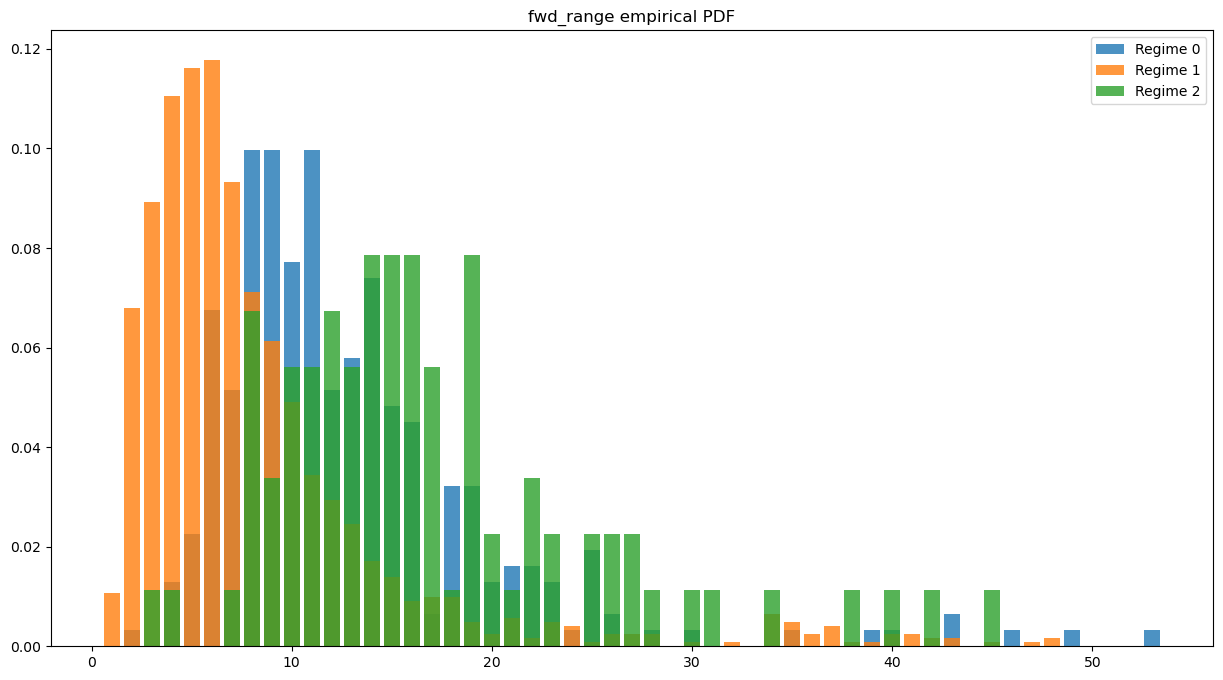

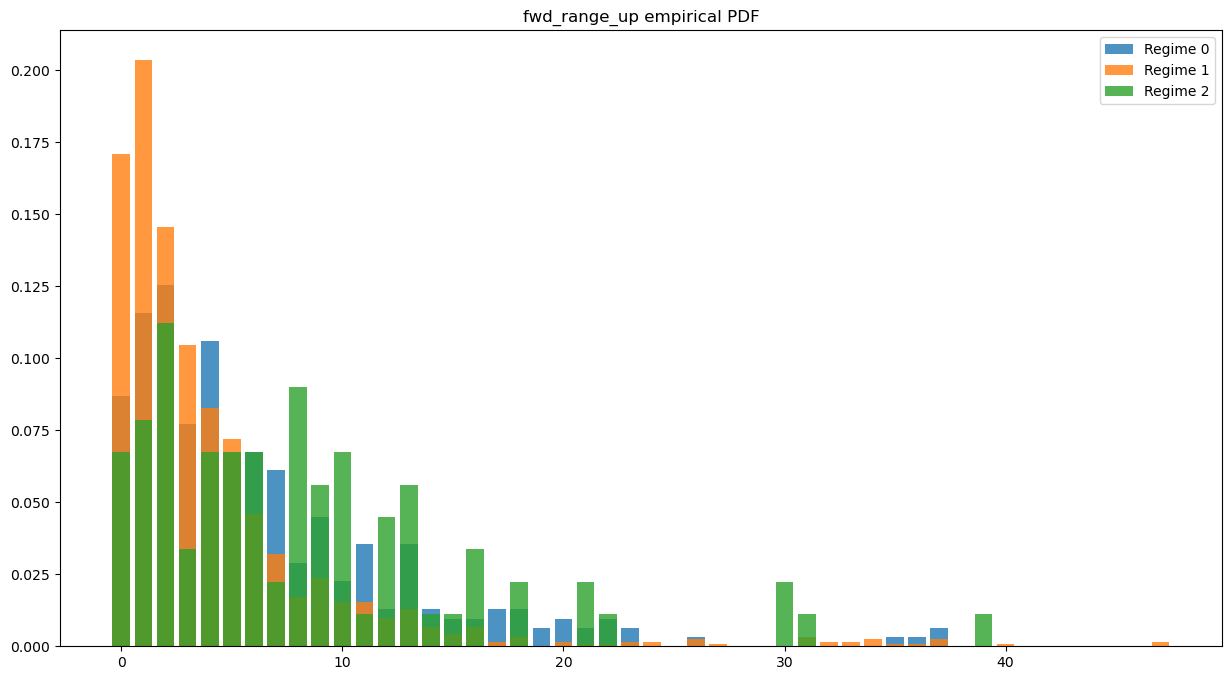

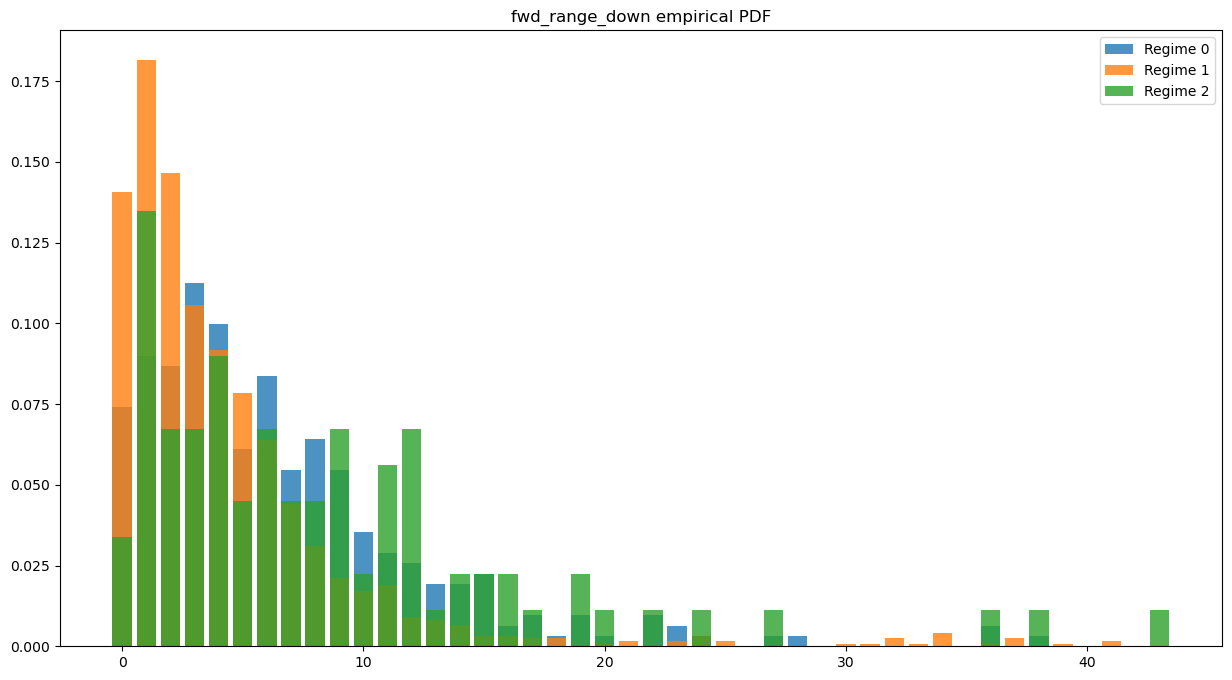

In [218]:
for response, df in empirical_pdfs.items():
    plt.figure(figsize=(15, 8))
    plt.title(f"{response} empirical PDF")
    for i in range(regimes):
        plt.bar(df[i].keys(), df[i].values, label=f"Regime {i}", alpha=0.8)
    plt.legend()

In [ ]:
kmean

In [224]:
optimizing_df = cv_df.copy()
optimizing_df["fwd_range"] = ((optimizing_df["high"] - optimizing_df["low"]) / tick_size).shift(-1)
optimizing_df["fwd_range_up"] = ((optimizing_df["high"] - optimizing_df["open"]) / tick_size).shift(-1)
optimizing_df["fwd_range_down"] = ((optimizing_df["open"] - optimizing_df["low"]) / tick_size).shift(-1)

optimizing_df["delta_feat"] = optimizing_df["close"].diff()
optimizing_df["volume_feat"] = optimizing_df["volume"]
optimizing_df["vol_feat"] = optimizing_df["delta_feat"].rolling(50).std()
optimizing_df = optimizing_df.iloc[int(partitions[0]*len(futures_df)):].copy()
optimizing_df.dropna(inplace=True)

kmeans.predict(optimizing_df[responses])

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- fwd_range
- fwd_range_down
- fwd_range_up
Feature names seen at fit time, yet now missing:
- delta_feat
- vol_feat
- volume_feat


In [214]:
optimizing_df

,open,high,low,close,volume,delta_feat,volume_feat,vol_feat
datetime,,,,,,,,
2020-05-07 12:00:00,847.25,847.75,845.50,845.75,3848,-1.50,3848,1.368272
2020-05-07 12:30:00,845.75,847.00,845.25,846.25,2959,0.50,2959,1.369306
2020-05-07 13:00:00,846.25,846.25,844.00,845.25,4260,-1.00,4260,1.377896
2020-05-07 13:30:00,845.50,845.50,844.00,844.25,3877,-1.00,3877,1.377896
2020-05-07 14:00:00,844.25,845.50,843.50,843.75,6624,-0.50,6624,1.376738
...,...,...,...,...,...,...,...,...
2020-05-27 23:00:00,848.75,848.75,847.75,848.00,392,-1.00,392,1.265002
2020-05-27 23:30:00,848.00,848.00,847.25,847.75,184,-0.25,184,1.256656
2020-05-28 00:00:00,847.75,848.00,847.50,847.75,177,0.00,177,1.256422


In [ ]:
# Optimize over CV set
# Comparisons 

In [ ]:
# Hyperparameters
# Volume: Raw(Quartile based) / SMA (Window size) / EMA (Weight)
# Volatility: SMA (Window size) / EMA (Weight)
# Cluster size: 